### 0.导入函数库

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from math import log10
from utilities.location import geiger_locate
from utilities.location import geiger_locate_lat_lon
from obspy import read_inventory
from obspy import read_events
from obspy import UTCDateTime, read
from obspy.geodetics import gps2dist_azimuth
from obspy.geodetics.base import locations2degrees
from obspy.geodetics.base import degrees2kilometers
from obspy.geodetics.base import kilometers2degrees
from obspy.taup import TauPyModel
from obspy.taup import plot_travel_times
import warnings
warnings.filterwarnings("ignore")
import logging
logging.basicConfig(
    format="%(name)s\t%(levelname)s\t%(message)s", 
    level=logging.INFO)

### 1.台站坐标转换

In [7]:
lat1=36.5
lon1=116.4
lat2=29.59
lon2=102.08

# 计算两点之间的距离
distance = locations2degrees(lat1, lon1, lat2, lon2)
print("distance(degress):", distance)

# 度转公里
kilometers = degrees2kilometers(lat1, radius=6371.0)
print("distance(kilometers):", kilometers)
# 公里转度
degrees = kilometers2degrees(4058.6, radius=6371.0)
print("distance(degrees):", degrees)
print("\n")
# 计算震中距、方位角、反方位角
distance,azimuth, bazimuth = gps2dist_azimuth(lat1, lon1, lat2, lon2)
print("distance:", distance)
print("azimuth: ", azimuth)
print("bazimuth:", bazimuth)

distance(degress): 13.828031225454456
distance(kilometers): 4058.6148225263937
distance(degrees): 36.499866697817595


distance: 1539054.5026222111
azimuth:  244.2593442023579
bazimuth: 56.407616836015805


### 2.震相到时与地震波路径

***(1)震中距与震相到时计算***

震相命名规则使用IASPEI命名规则（与国内常用命名规则不完全相同），参考 <a href="http://www.isc.ac.uk/standards/phases/">http://www.isc.ac.uk/standards/phases/</a>
<br><br>
速度模型参考：<br>
<ul class="simple">
<li><p><code class="docutils literal notranslate"><span class="pre">1066a</span></code>, see <a class="reference internal" href="" id="id2"><span>[GilbertDziewonski1975]</span></a></p></li>
<li><p><code class="docutils literal notranslate"><span class="pre">1066b</span></code>, see <a class="reference internal" href="" id="id3"><span>[GilbertDziewonski1975]</span></a></p></li>
<li><p><code class="docutils literal notranslate"><span class="pre">ak135</span></code>, see <a class="reference internal" href="" id="id4"><span>[KennetEngdahlBuland1995]</span></a></p></li>
<li><p><code class="docutils literal notranslate"><span class="pre">ak135f</span></code>, see <a class="reference internal" href="" id="id5"><span>[KennetEngdahlBuland1995]</span></a>, <a class="reference internal" href="" id="id6"><span>[MontagnerKennett1995]</span></a>, and
<a class="reference external" href="http://rses.anu.edu.au/seismology/ak135/ak135f.html">http://rses.anu.edu.au/seismology/ak135/ak135f.html</a> (not supported)</p></li>
<li><p><code class="docutils literal notranslate"><span class="pre">ak135f_no_mud</span></code>, <code class="docutils literal notranslate"><span class="pre">ak135f</span></code> with <code class="docutils literal notranslate"><span class="pre">ak135</span></code> used above the 120-km
discontinuity; see the SPECFEM3D_GLOBE manual at
<a class="reference external" href="https://geodynamics.org/cig/software/specfem3d_globe/">https://geodynamics.org/cig/software/specfem3d_globe/</a></p></li>
<li><p><code class="docutils literal notranslate"><span class="pre">herrin</span></code>, see <a class="reference internal" href="" id="id7"><span>[Herrin1968]</span></a></p></li>
<li><p><code class="docutils literal notranslate"><span class="pre">iasp91</span></code>, see <a class="reference internal" href="" id="id8"><span>[KennetEngdahl1991]</span></a></p></li>
<li><p><code class="docutils literal notranslate"><span class="pre">jb</span></code>, see <a class="reference internal" href="" id="id9"><span>[JeffreysBullen1940]</span></a></p></li>
<li><p><code class="docutils literal notranslate"><span class="pre">prem</span></code>, see <a class="reference internal" href="" id="id10"><span>[Dziewonski1981]</span></a></p></li>
<li><p><code class="docutils literal notranslate"><span class="pre">pwdk</span></code>, see <a class="reference internal" href="" id="id11"><span>[WeberDavis1990]</span></a></p></li>
<li><p><code class="docutils literal notranslate"><span class="pre">sp6</span></code>, see <a class="reference internal" href="" id="id12"><span>[MorelliDziewonski1993]</span></a></p></li>
</ul>

P phase arrival:                2022-09-10T23:56:08.589718
pP phase arrival:               2022-09-10T23:56:28.553355
sP phase arrival:               2022-09-10T23:56:37.840798
PcP phase arrival:              2022-09-10T23:57:15.056068
PP phase arrival:               2022-09-10T23:58:09.532647
PP phase arrival:               2022-09-10T23:58:17.254897
PP phase arrival:               2022-09-10T23:58:17.486382
ScP phase arrival:              2022-09-11T00:01:05.288696
PcS phase arrival:              2022-09-11T00:01:14.142777
S phase arrival:                2022-09-11T00:03:34.667212
SP phase arrival:               2022-09-11T00:03:42.355471
PKiKP phase arrival:            2022-09-11T00:03:52.022639
sS phase arrival:               2022-09-11T00:04:09.359665
pPKiKP phase arrival:           2022-09-11T00:04:14.665879
sPKiKP phase arrival:           2022-09-11T00:04:23.329242
ScS phase arrival:              2022-09-11T00:05:50.236372
SS phase arrival:               2022-09-11T00:07:16.8336

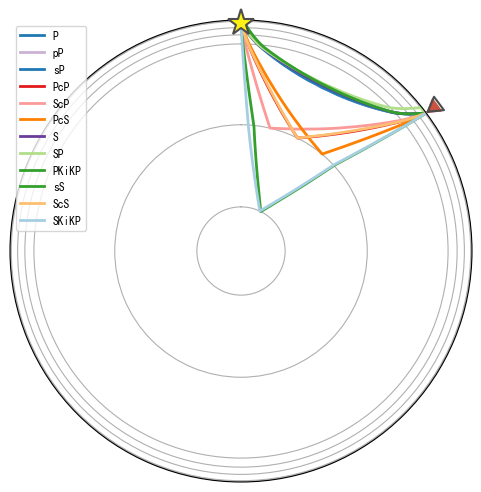

<PolarAxes: >

In [8]:
# 震源深度，单位：公里
source_dep = 80.0
# 震源纬度，单位：度
source_lat = -6.22
# 震源经度，单位：度
source_lon = 146.48
# 发震时间
seis_time = "2022-09-10T23:46:58"
# 震相
phases = ["P", "S"]
# 选择速度模型,支持以下速度模型和自定义taup模型
tau_model = TauPyModel(model="iasp91")

plt.rcParams['figure.figsize'] = 6, 6

# 震中距与震相到时计算
inventory = read_inventory("../data/spec_test.xml")
seis_time = UTCDateTime(seis_time)
for inv in inventory:
    for i in inv:
        arrivals = tau_model.get_travel_times_geo(source_depth_in_km=source_dep,
                                                    source_latitude_in_deg=source_lat,
                                                    source_longitude_in_deg=source_lon,
                                                    receiver_latitude_in_deg=i.latitude,
                                                    receiver_longitude_in_deg=i.longitude,
                                                    phase_list=phases)
        purist_distance = arrivals[0].purist_distance

        arrivals = tau_model.get_travel_times(source_depth_in_km=source_dep, distance_in_degree=purist_distance)
        for arr in arrivals:
            arr_time = (seis_time + arr.time).strftime("%Y-%m-%dT%H:%M:%S.%f")
            str_phase = arr.name + " phase arrival: "
            str_phase = str_phase.ljust(32,' ')
            print(str_phase + arr_time)
            
ray_phases = ['P', 'pP', 'sP', 'PcP', 'ScP', 'PcS', 'S', 'SP', 'sS', 'ScS', 'PKiKP', 'SKiKP']
ray_arrivals = tau_model.get_ray_paths(source_dep, purist_distance, phase_list=ray_phases)
ray_arrivals.plot_rays(plot_type='spherical', phase_list=ray_phases, legend=True)

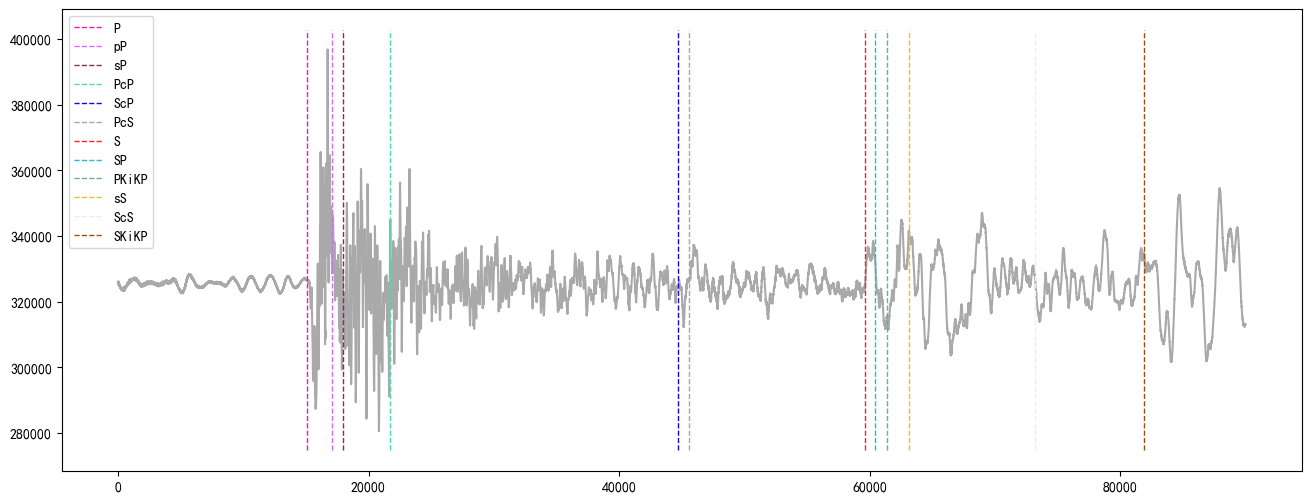

In [9]:
# 发震时间(UTC时间)
seis_time = "2022-09-10T23:46:58"
# 震前时间长度（单位：秒）
seis_bef = -400
# 震后时间长度（单位：秒）
seis_aft = 900 - seis_bef
seis_time = UTCDateTime(seis_time)
start_time = seis_time - seis_bef
end_time = seis_time + seis_aft

# 绘图
plt.rcParams['figure.figsize'] = 16, 6
st = read("../data/event_test1.mseed")
st = st.merge(fill_value=0)
ax1 = plt.subplot(111)
plt.plot(st[0].data, color='#A9A9A9')

ymin, ymax = ax1.get_ylim()

sample = st[0].stats.sampling_rate
import random
for arr in ray_arrivals:
    phase_x = ((seis_time + arr.time) - start_time) * sample
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
    ax1.vlines(phase_x, ymin, ymax, color=color, linestyles='dashed', linewidth=1, label=arr.name)
plt.legend()
plt.show()


***(2)给定距离范围和深度，绘制用iasp91速度模型计算的走时***

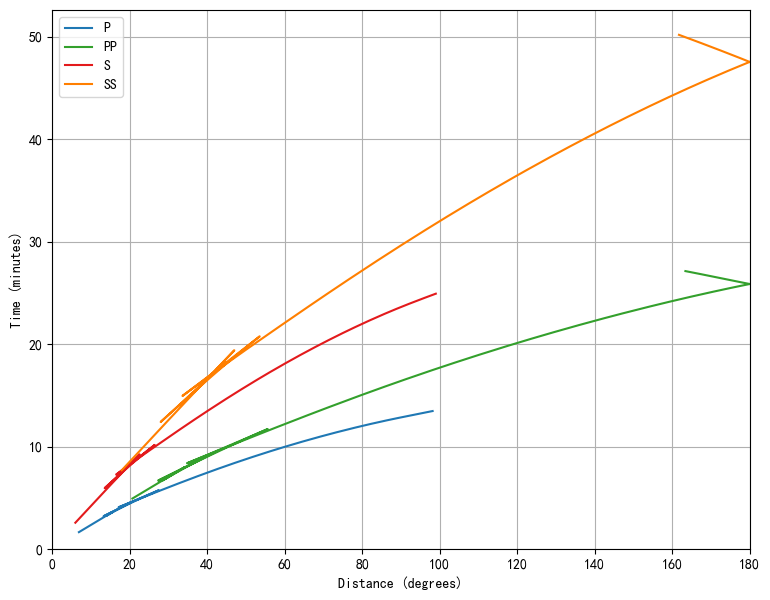

In [10]:
plt.rcParams['figure.figsize'] = 9, 7
fig, ax = plt.subplots()
ax = plot_travel_times(source_depth=source_dep, ax=ax, fig=fig, phase_list=['P', 'PP', 'S', 'SS'])

***(3)绘制给定距离和震相的射线路径***

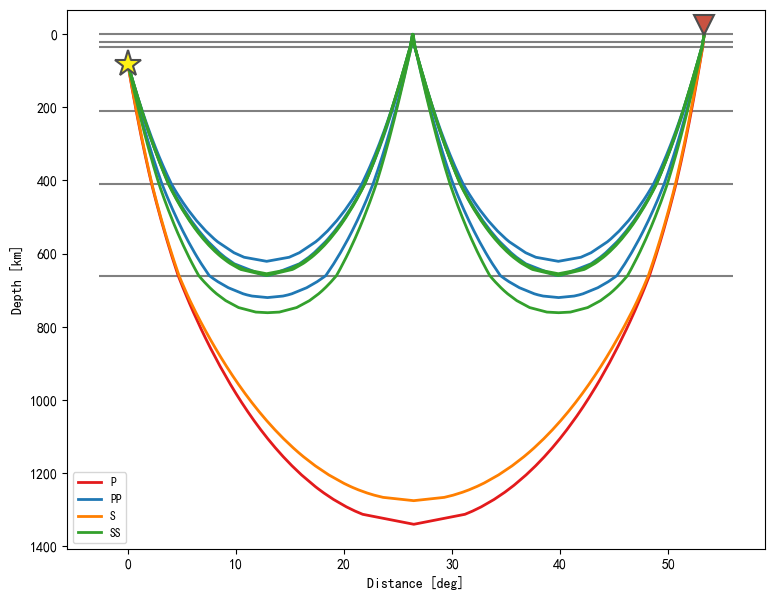

P 550.5897126052339
PP 671.5326345659591
PP 679.2548926068105
PP 679.4864590585064
S 996.6672105227785
SS 1218.8336503230141
SS 1240.6099553993665
SS 1240.6162643023429


In [11]:
arrivals = tau_model.get_ray_paths(source_dep, purist_distance, phase_list=['P','PP', 'S', 'SS'])
arrivals.plot_rays(plot_type='cartesian', phase_list=['PP', 'SS'], plot_all=False, legend=True)
for arr in arrivals:
    print(arr.name, arr.time)

### 3.geiger计算
```
下面练习只考虑使用单层均匀速度模型
```

***（1）使用理论值***

Geiger	INFO	Starting model has residual of 3.18
Geiger	INFO	Result updated to: (time 0.31, x 10.59, y 4.34 z 11.57)
Geiger	INFO	Updated Result has residual of 0.70
Geiger	INFO	Result updated to: (time -0.00, x 10.02, y 4.00 z 12.02)
Geiger	INFO	Updated Result has residual of 0.01
Geiger	INFO	Result updated to: (time 0.00, x 10.00, y 4.00 z 12.00)
Geiger	INFO	Updated Result has residual of 0.00
Geiger	INFO	Model has reached convergence threshold


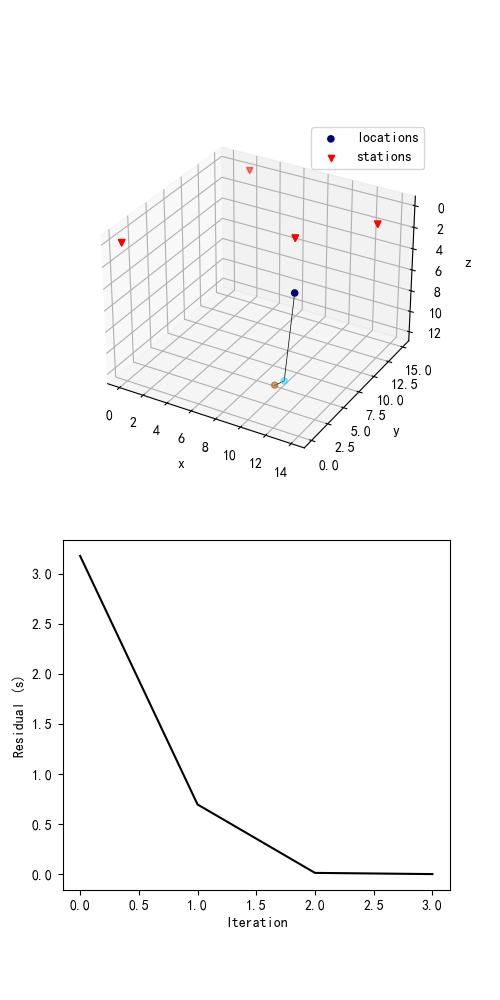

Found a solution at x = 10.00, y = 4.00, z = 12.00, time = 0.00


In [12]:
%matplotlib widget
known_location = {"x": 10.0, "y": 4.0, "z": 12.0, "time": 0.0}
vp = 5.0
vs = 3.0

stations = [
    {"x": 0, "y": 0, "z": 0},
    {"x": 2, "y": 15, "z": 0},
    {"x": 10, "y": 7, "z": 0},
    {"x": 14, "y": 12, "z": 0}]

p_times = np.zeros(len(stations))
s_times = np.zeros_like(p_times)

for i, station in enumerate(stations):
    distance = (
        (station["x"] - known_location["x"]) ** 2 +
        (station["y"] - known_location["y"]) ** 2 + 
        (station["z"] - known_location["z"]) ** 2) ** 0.5
    p_times[i] = distance / vp
    s_times[i] = distance / vs

inverted_model = geiger_locate(
    p_times=p_times, p_locations=stations, s_times=s_times,
    s_locations=stations, vp=vp, vs=vs, starting_depth=5.0, plot=True)

print("Found a solution at x = {0:.2f}, y = {1:.2f}, z = {2:.2f}, "
      "time = {3:.2f}".format(inverted_model["x"], inverted_model["y"],
                              inverted_model["z"], inverted_model["time"]))

***（2）加入随机干扰***

Geiger	INFO	Starting model has residual of 3.85
Geiger	INFO	Result updated to: (time 0.80, x 8.88, y 4.02 z 8.97)
Geiger	INFO	Updated Result has residual of 0.73
Geiger	INFO	Result updated to: (time 0.76, x 8.25, y 3.84 z 8.48)
Geiger	INFO	Updated Result has residual of 0.55
Geiger	INFO	Result updated to: (time 0.76, x 8.27, y 3.86 z 8.44)
Geiger	INFO	Updated Result has residual of 0.55
Geiger	INFO	Model has reached convergence threshold


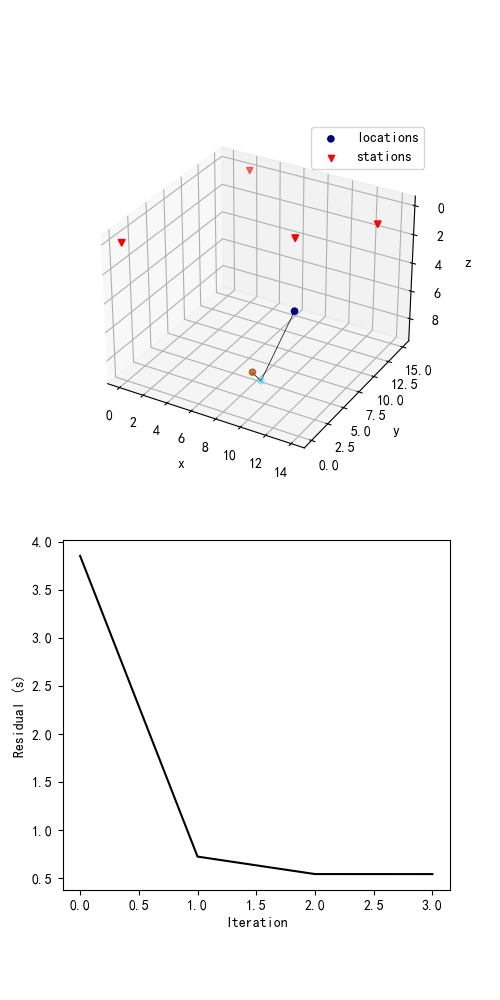

Solution at x = 8.27, y = 3.86, z = 8.44, time = 0.76


In [13]:
np.random.seed(42)
p_times = [time + np.random.sample() - .5 for time in p_times]
s_times = [time + np.random.sample() - .5 for time in s_times]

inverted_model = geiger_locate(
    p_times=p_times, p_locations=stations, s_times=s_times,
    s_locations=stations, vp=vp, vs=vs, starting_depth=5.0, plot=True)

print("Solution at x = {0:.2f}, y = {1:.2f}, z = {2:.2f}, "
      "time = {3:.2f}".format(inverted_model["x"], inverted_model["y"],
                              inverted_model["z"], inverted_model["time"]))

***（3）增加台站密度***

Geiger	INFO	Starting model has residual of 6.03
Geiger	INFO	Result updated to: (time 0.21, x 10.10, y 4.44 z 11.89)
Geiger	INFO	Updated Result has residual of 1.63
Geiger	INFO	Result updated to: (time -0.09, x 10.30, y 3.96 z 12.07)
Geiger	INFO	Updated Result has residual of 1.11
Geiger	INFO	Result updated to: (time -0.09, x 10.30, y 3.95 z 12.06)
Geiger	INFO	Updated Result has residual of 1.11
Geiger	INFO	Result updated to: (time -0.09, x 10.30, y 3.95 z 12.06)
Geiger	INFO	Updated Result has residual of 1.11
Geiger	INFO	Result updated to: (time -0.09, x 10.30, y 3.95 z 12.06)
Geiger	INFO	Updated Result has residual of 1.11
Geiger	INFO	Model has reached convergence threshold


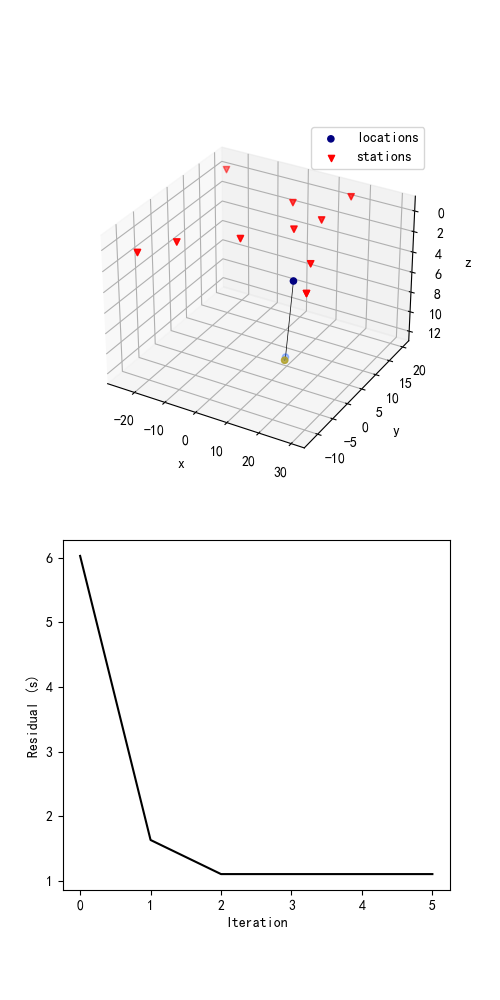

Found a solution at x = 10.30, y = 3.95, z = 12.06, time = -0.09


In [14]:
stations = [
    {"x": 0, "y": 0, "z": 0},
    {"x": 2, "y": 15, "z": 0},
    {"x": 10, "y": 7, "z": 0},
    {"x": 14, "y": 12, "z": 0},
    {"x": 20, "y": 2, "z": 1.2},
    {"x": 16, "y": 20, "z": -0.5},
    {"x": -20, "y": -12, "z": 0},
    {"x": -14, "y": -6, "z": 0},
    {"x": 30, "y": -10, "z": 0},
    {"x": -25, "y": 20, "z": 0}]

p_times = np.zeros(len(stations))
s_times = np.zeros_like(p_times)

for i, station in enumerate(stations):
    distance = (
        (station["x"] - known_location["x"]) ** 2 +
        (station["y"] - known_location["y"]) ** 2 + 
        (station["z"] - known_location["z"]) ** 2) ** 0.5
    p_times[i] = distance / vp
    s_times[i] = distance / vs

p_times = [time + np.random.sample() - .5 for time in p_times]
s_times = [time + np.random.sample() - .5 for time in s_times]
    
inverted_model = geiger_locate(
    p_times=p_times, p_locations=stations, s_times=s_times,
    s_locations=stations, vp=vp, vs=vs, convergence=0.00001, 
    starting_depth=5.0, plot=True)

print("Found a solution at x = {0:.2f}, y = {1:.2f}, z = {2:.2f}, "
      "time = {3:.2f}".format(inverted_model["x"], inverted_model["y"],
                              inverted_model["z"], inverted_model["time"]))

***（4）使用真实数据测试***

Geiger	INFO	Starting model has residual of 15.90
Geiger	INFO	Result updated to: (time -3.18, x 9.45, y -5.84 z 17.34)
Geiger	INFO	Updated Result has residual of 3.19
Geiger	INFO	Result updated to: (time -3.35, x 9.41, y -5.61 z 15.39)
Geiger	INFO	Updated Result has residual of 2.80
Geiger	INFO	Result updated to: (time -3.35, x 9.42, y -5.61 z 15.23)
Geiger	INFO	Updated Result has residual of 2.80
Geiger	INFO	Result updated to: (time -3.35, x 9.42, y -5.61 z 15.22)
Geiger	INFO	Updated Result has residual of 2.80
Geiger	INFO	Model has reached convergence threshold


7 S picks and 15 P picks.


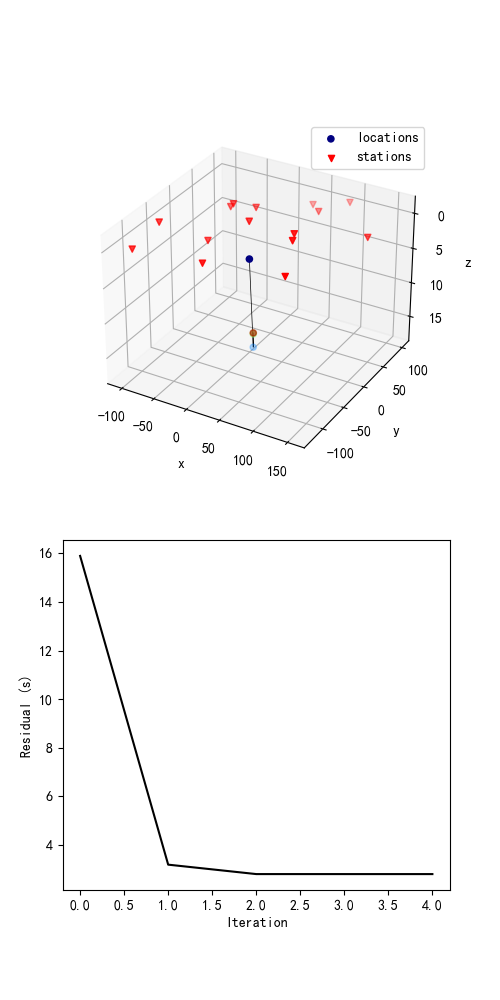

GeoNet location: -44.27 latitude, 169.36 longitude, 5.26 depth (km) 2019-05-08T20:03:32.781766Z origin time
Test location: -44.28 latitude, 169.35 longitude, 15.22 depth (km) 2019-05-08T20:03:32.479961Z origin time


In [15]:
event = read_events("../data/event_2019345502.xml")[0]
inventory = read_inventory("../data/stations_2019345502.xml")

p_times, p_locations, s_times, s_locations = ([], [], [], [])

for pick in event.picks:
    try:
        loc = inventory.get_coordinates(pick.waveform_id.get_seed_string())
    except:
        print("No location found for {0}".format(
            pick.waveform_id.get_seed_string()))
        continue
    if pick.phase_hint == "P":
        p_times.append(pick.time)
        p_locations.append(
            {"lat": loc["latitude"], "lon": loc["longitude"], 
             "z": loc["elevation"] / 1000.})
    elif pick.phase_hint == "S":
        s_times.append(pick.time)
        s_locations.append(
            {"lat": loc["latitude"], "lon": loc["longitude"], 
             "z": loc["elevation"] / 1000.})

print(f"{len(s_times)} S picks and {len(p_times)} P picks.")

model = geiger_locate_lat_lon(p_times, p_locations, s_times, s_locations, vp=5.8,
                              vs=3.36, plot=True, starting_depth=5.)

print("GeoNet location: {0:.2f} latitude, {1:.2f} longitude, {2:.2f} depth (km) {3} origin time".format(
    event.preferred_origin().latitude, event.preferred_origin().longitude,
    event.preferred_origin().depth / 1000., event.preferred_origin().time))
print("Test location: {0:.2f} latitude, {1:.2f} longitude, {2:.2f} depth (km) {3} origin time".format(
    model["lat"], model["lon"], model["z"], model["time"]))

### 4.震级计算

In [16]:
st = read("../data/LKBD.MSEED")

paz_le3d5s = {'gain': 1.009,
              'poles': [-0.885 + 0.887j,
                        -0.885 - 0.887j,
                        -0.427 + 0j],
              'sensitivity': 167364000.0,
              'zeros': [0j, 0j, 0j]}
paz_wa = {'sensitivity': 2800, 'zeros': [0j], 'gain': 1,
          'poles': [-6.2832 - 4.7124j, -6.2832 + 4.7124j]}

st.simulate(paz_remove=paz_le3d5s, paz_simulate=paz_wa, water_level=10)

t = UTCDateTime("2012-04-03T02:45:03")
st.trim(t, t + 50)

tr_n = st.select(component="N")[0]
ampl_n = max(abs(tr_n.data))
tr_e = st.select(component="E")[0]
ampl_e = max(abs(tr_e.data))
ampl = max(ampl_n, ampl_e)

sta_lat = 46.38703
sta_lon = 7.62714
event_lat = 46.218
event_lon = 7.706

epi_dist, az, baz = gps2dist_azimuth(event_lat, event_lon, sta_lat, sta_lon)
epi_dist = epi_dist / 1000

ml = log10(ampl * 1000) + 0.018 * epi_dist + 2.17
print("SED Ml = {0:.2f}".format(ml))
#
ml = log10(ampl * 1e6) + 1.11 * log10(epi_dist) + 0.00189 * epi_dist - 2.09
print("IASPEI Ml = {0:.2f}".format(ml))

SED Ml = 2.59
IASPEI Ml = 2.45


<video src="mag_1.mp4" controls title="Title"></video>